In [1]:
# Импорты

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, f1_score, classification_report, 
                             confusion_matrix, ConfusionMatrixDisplay, 
                             roc_auc_score, roc_curve)

import joblib

In [2]:
# Загрузка датасета

df = pd.read_csv('scoring_dataset.csv')
df.head()

,id,a,b,c,d,e,f,g,h,sex,...,children,property,r,employment_status,t,u,v,w,x,target
0,1,0.205745,0.102347,5.789606,915.200880,1.768483,0.911097,14,3.468871,Woman,...,2 Two,property,No,Works,Yes,Yes,No,Yes,No,0
1,2,0.019220,0.041618,64.581390,301.619343,0.403651,0.060439,13,3.613679,Woman,...,2 Two,otherwise,No,Works,Yes,Yes,Yes,Yes,No,0
2,3,0.084232,0.071406,0.000000,366.024590,0.651506,0.464642,14,3.603402,Woman,...,1 One,property,No,No couple,No,Yes,No,Yes,No,0
3,4,0.074207,0.042716,0.000000,295.858510,0.307611,0.367238,13,3.350909,Woman,...,0 Zero,property,No,No couple,Yes,Yes,Few,Yes,No,0
4,5,0.097268,0.170796,21.342615,594.180379,1.342676,1.287787,13,3.317590,Woman,...,0 Zero,property,No,No couple,Yes,No,No,No,No,0


In [3]:
df.columns

Index(['id', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'sex', 'age', 'region',
       'l', 'job_title', 'education', 'marriage', 'children', 'property', 'r',
       'employment_status', 't', 'u', 'v', 'w', 'x', 'target'],
      dtype='object')

Пропуски: 0


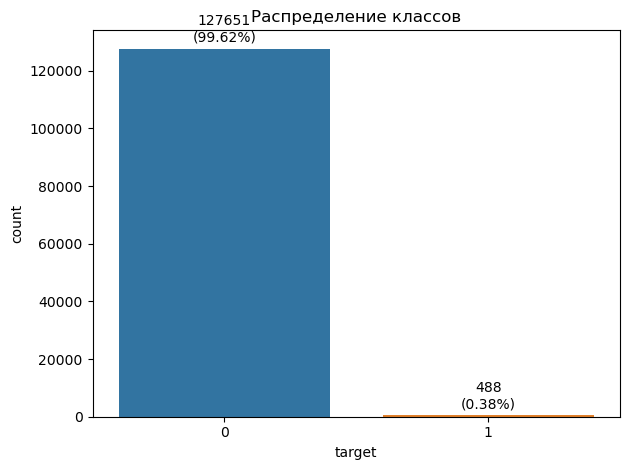

In [4]:
# Количество пропусков и распределение классов

print(f'Пропуски: {df.isna().sum().sum()}')

ax = sns.countplot(x='target', data=df, hue='target', legend=False)
plt.title('Распределение классов')

total = len(df)
for p in ax.patches:
    count = int(p.get_height())
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(f'{count}\n({count/total:.2%})', (x, y),
                ha='center', va='bottom', xytext=(0, 3), 
                textcoords='offset points')

plt.tight_layout()
plt.show()

In [5]:
# Удаление лишнего столбца и дублей

df = df.drop('id', axis=1)
df.head()

n_before = len(df)
df = df.drop_duplicates(ignore_index=True)
print(f'Удалено дублей: {n_before - len(df)}\nИтоговый размер: {df.shape}')
df.head()

Удалено дублей: 0
Итоговый размер: (128139, 25)


,a,b,c,d,e,f,g,h,sex,age,...,children,property,r,employment_status,t,u,v,w,x,target
0,0.205745,0.102347,5.789606,915.200880,1.768483,0.911097,14,3.468871,Woman,33.333598,...,2 Two,property,No,Works,Yes,Yes,No,Yes,No,0
1,0.019220,0.041618,64.581390,301.619343,0.403651,0.060439,13,3.613679,Woman,30.193912,...,2 Two,otherwise,No,Works,Yes,Yes,Yes,Yes,No,0
2,0.084232,0.071406,0.000000,366.024590,0.651506,0.464642,14,3.603402,Woman,40.473346,...,1 One,property,No,No couple,No,Yes,No,Yes,No,0
3,0.074207,0.042716,0.000000,295.858510,0.307611,0.367238,13,3.350909,Woman,61.621774,...,0 Zero,property,No,No couple,Yes,Yes,Few,Yes,No,0
4,0.097268,0.170796,21.342615,594.180379,1.342676,1.287787,13,3.317590,Woman,51.969999,...,0 Zero,property,No,No couple,Yes,No,No,No,No,0


In [6]:
# Сплит, преобразование категориальных переменных и скейлинг

X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    stratify=y, random_state=42)

num = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat = X_train.columns.difference(num).tolist()

encoders = {}
X_train_le = X_train.copy()
X_test_le  = X_test.copy()

for c in cat:
    le = LabelEncoder()
    X_train_le[c] = le.fit_transform(X_train_le[c].astype(str))
    mapping = {cls: idx for idx, cls in enumerate(le.classes_)}
    X_test_le[c] = X_test_le[c].astype(str).map(mapping)
    X_test_le[c] = X_test_le[c].fillna(-1).astype(int)
    encoders[c] = le

scaler = StandardScaler()
X_train_le.loc[:, num] = scaler.fit_transform(X_train_le[num].astype('float64'))
X_test_le.loc[:,  num] = scaler.transform(X_test_le[num].astype('float64'))

print('Размер train:', X_train_le.shape, 'Размер test:', X_test_le.shape)
print('\nРаспределение классов (train):')
classes_cnt = pd.DataFrame(y_train.value_counts())
display(classes_cnt)

Размер train: (102511, 24) Размер test: (25628, 24)

Распределение классов (train):


C:\Users\aloeseasnn\AppData\Local\Temp\ipykernel_13588\282295501.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 2.71640945  0.23399032 -0.80035098 ... -1.00721925 -1.21408751
 -1.00721925]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train_le.loc[:, num] = scaler.fit_transform(X_train_le[num].astype('float64'))
C:\Users\aloeseasnn\AppData\Local\Temp\ipykernel_13588\282295501.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.68736918  0.19311597 -0.75662082 ... -0.48950735 -0.61811754
 -0.41036261]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train_le.loc[:, num] = scaler.fit_transform(X_train_le[num].astype('float64'))
C:\Users\aloeseasnn\AppData\Local\Temp\ipykernel_13588\282295501.py:26: FutureWarning: Setting an item of incompatible d

,count
target,
0,102121
1,390


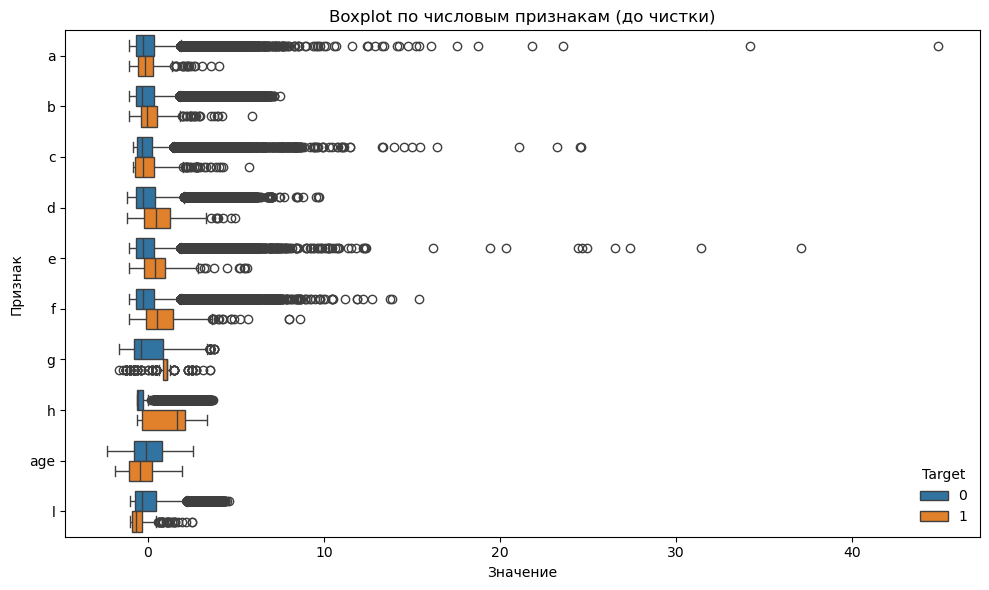

In [7]:
# Выбросы

Xn = X_train_le[num].astype(float)
long = pd.concat([Xn, y_train.rename('target')], axis=1).melt(id_vars='target', var_name='feature', value_name='value')

h = max(6, 0.35*len(num))
plt.figure(figsize=(10, h))
ax = sns.boxplot(data=long, y='feature', x='value', hue='target', 
                 orient='h', showfliers=True)
ax.set_title('Boxplot по числовым признакам (до чистки)')
ax.set_xlabel('Значение'); ax.set_ylabel('Признак')
ax.legend(title='Target', frameon=False)
plt.tight_layout()
plt.show()

In [8]:
# Очистка выбросов

def mad_outlier_mask(X_num, z_thresh=5.0, min_feats=2):
    Xv = X_num.values.astype(float)
    med = np.median(Xv, axis=0)
    mad = np.median(np.abs(Xv - med), axis=0)
    mad = np.where(mad == 0, 1e-9, mad)
    rz = 0.6745 * (Xv - med) / mad
    hits = (np.abs(rz) > z_thresh).sum(axis=1)
    return (hits >= min_feats)

mask_c0 = (y_train == 0)
out_c0 = pd.Series(False, index=y_train.index)
if len(num) > 0 and mask_c0.any():
    out_c0.loc[mask_c0] = mad_outlier_mask(X_train_le.loc[mask_c0, num], z_thresh=5.0, min_feats=2)

print('Выбросов в классе 0 (train):', int(out_c0.sum()))

keep_mask = ~out_c0
X_train_cln = X_train_le.loc[keep_mask].copy()
y_train_cln = y_train.loc[keep_mask].copy()

print('Размер после чистки:', X_train_cln.shape, '\n\nКлассы:')
display(pd.DataFrame(y_train_cln.value_counts()))

Выбросов в классе 0 (train): 3239
Размер после чистки: (99272, 24) 

Классы:


,count
target,
0,98882
1,390


In [9]:
# Логистическая регрессия для определения важности признаков и их отбора

classes_cnt = y_train_cln.value_counts()
w0 = float(1 - classes_cnt.loc[0] / classes_cnt.sum())
w1 = float(1 - classes_cnt.loc[1] / classes_cnt.sum())

lr_base = LogisticRegression(solver='lbfgs', max_iter=2000,
                             class_weight={0: w0, 1: w1})
lr_base.fit(X_train_cln, y_train_cln)

coef = np.abs(lr_base.coef_)
print(coef)
coef_max = coef.max(axis=0)
std_train = X_train_cln.std(axis=0).replace(0, 1e-12).values
effect = coef_max * std_train

imp = pd.DataFrame(effect, index=X_train_cln.columns, 
                   columns=['Влияние признака']).sort_values('Влияние признака', ascending=False)

KEEP_FRAC = 0.7
min_keep = 20
k = max(min_keep, int(len(imp) * KEEP_FRAC))

keep_cols = imp.index[:k].tolist()
drop_cols = imp.index[k:].tolist()

print(f'\nВсего признаков: {len(imp)}\nОставляем: {len(keep_cols)}\nУдаляем: {len(drop_cols)}')
print('\n10 лучших признаков по вкладу:')
display(imp.head(10))

X_train_fs = X_train_cln[keep_cols].copy()
X_test_fs  = X_test_le[keep_cols].copy()

[[0.01460511 0.19481276 0.14093375 0.49683077 0.20291626 0.14750172
  0.11888998 0.90592455 0.33651265 0.15613257 0.00172197 0.65390156
  0.29769163 0.35211311 0.13109531 0.16195963 0.04469291 0.81658338
  0.18223045 0.04055319 0.39133927 0.19166514 0.52224639 0.41698212]]

Всего признаков: 24
Оставляем: 20
Удаляем: 4

10 лучших признаков по вкладу:


,Влияние признака
h,0.906950
l,0.645679
education,0.497876
d,0.445934
employment_status,0.323743
r,0.307944
w,0.258400
job_title,0.231522
x,0.202688
b,0.171020


In [10]:
# Обучение основной модели

model = LogisticRegression(solver='lbfgs', max_iter=2000,
                           class_weight={0: w0, 1: w1})
model.fit(X_train_fs, y_train_cln)

y_pred = model.predict(X_test_fs)
y_proba = model.predict_proba(X_test_fs)

print(f'Accuracy:  {accuracy_score(y_test, y_pred):.4f}')
print(f'F1-macro:  {f1_score(y_test, y_pred, average='macro'):.4f}\n')
print('Отчёт:\n', classification_report(y_test, y_pred, digits=4))

Accuracy:  0.7857
F1-macro:  0.4538

Отчёт:
               precision    recall  f1-score   support

           0     0.9991    0.7857    0.8796     25530
           1     0.0142    0.8061    0.0280        98

    accuracy                         0.7857     25628
   macro avg     0.5066    0.7959    0.4538     25628
weighted avg     0.9953    0.7857    0.8763     25628



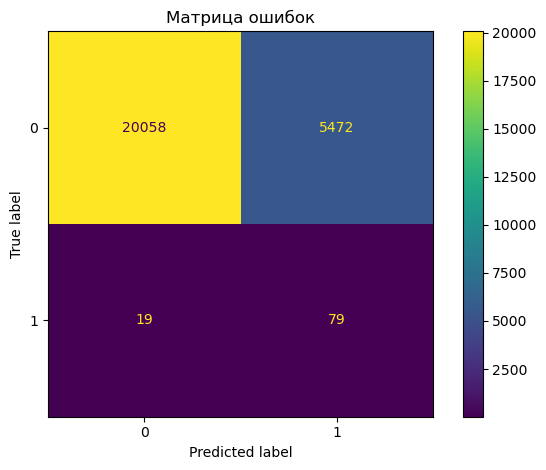

In [11]:
# Матрица ошибок

labels = model.classes_

cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(values_format='d')
plt.grid(False)
plt.title('Матрица ошибок')
plt.tight_layout()
plt.show()

В задаче кредитного скоринга стоимость ошибок "асимметрична"

В случае если мы пропускаем дефолт (получаем FN значение), то мы рискуем убытком, а это дорого. В случае FP-значения мы упускаем прибыль или получаем недовольство клиента, однако вероятно дешевле чем получить убыток

Поэтому в этой задаче наиболее важно значение recall, поскольку:
- модель имеет высокий accuracy, почти не находя класс 1 таргета из-за асимметрии
- низкий recall означает, что модель пропускает большинство дефолтов, что недопустимо

Macro ROC-AUC (OvR): 0.8608


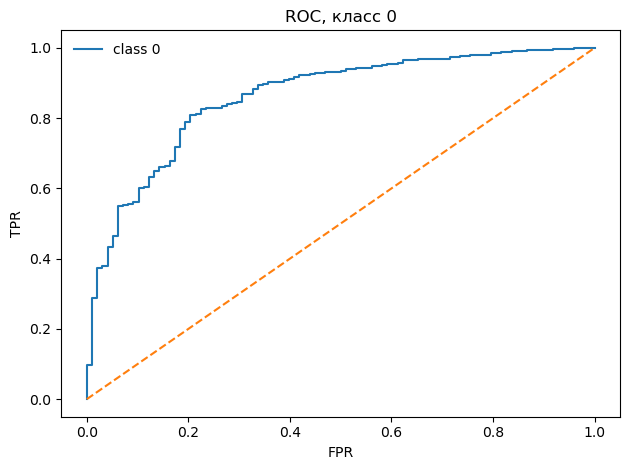

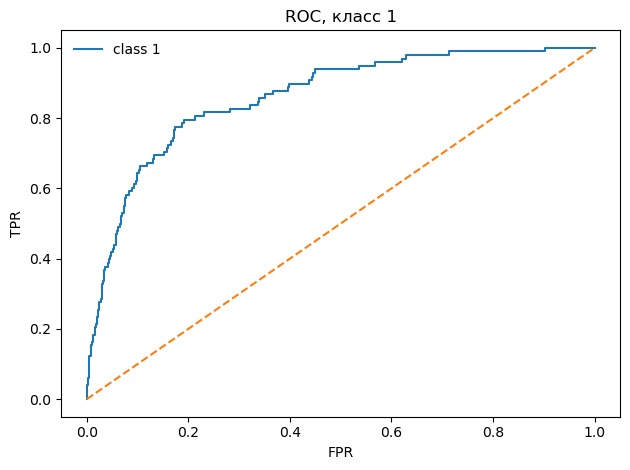

In [12]:
# Кривые обучения

classes = np.array(labels)
idx = {c: i for i, c in enumerate(classes)}

macro_auc = roc_auc_score(y_test, y_proba[:, 1]) if len(classes) == 2 else roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')
print(f'Macro ROC-AUC (OvR): {macro_auc:.4f}')

top = classes if len(classes) == 2 else y_test.value_counts().reindex(classes).nlargest(3).index

for cls in top:
    yb = (y_test == cls).astype(int)
    p = (y_proba[:, 1] if cls == classes[1] else 1 - y_proba[:, 1]) if len(classes) == 2 else y_proba[:, idx[cls]]
    fpr, tpr, _ = roc_curve(yb, p)
    plt.figure()
    plt.plot(fpr, tpr, label=f'class {cls}')
    plt.plot([0, 1], [0, 1], '--')
    plt.xlabel('FPR'); plt.ylabel('TPR')
    plt.title(f'ROC, класс {cls}')
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.show()

Обе кривые выше диагонали, следовательно модель хорошо ранжирует данные обоих классов

Кривая класса 1 чуть левее и чуть выше, чем кривая для класса 0. При одинаковом FPR модель получает больший TPR

In [13]:
# Сохранение модели

artifact = {'model': model, 'scaler': scaler, 'num_cols': list(num), 
            'cat_cols': list(cat), 'feature_order': list(X_train_le.columns), 
            'feature_subset': list(keep_cols), 'encoders': encoders}
joblib.dump(artifact, 'scoring_logreg.pkl')

['scoring_logreg.pkl']

In [14]:
# Предобработка для новых данных

def _apply_label_encoders(df, encoders):
    df = df.copy()
    for c, le in encoders.items():
        if c not in df.columns:
            df[c] = -1
            continue
        vals = df[c].astype(str)
        mapping = {cls: idx for idx, cls in enumerate(le.classes_)}
        df[c] = vals.map(mapping).fillna(-1).astype(int)
    return df

def _preprocess(df_raw, art):
    df = df_raw.copy()
    if 'id' in df.columns:
        df = df.drop(columns=['id'])
    if art.get('encoders'):
        df = _apply_label_encoders(df, art['encoders'])
    num_cols = art.get('num_cols', [])
    if len(num_cols):
        df.loc[:, num_cols] = art['scaler'].transform(df[num_cols].astype(float))
    expected = art.get('feature_subset')
    for col in expected:
        if col not in df.columns:
            df[col] = 0
    X = df[expected]
    return X

def predict_labels(df_new: pd.DataFrame, artifact_path='scoring_logreg.pkl',
                   threshold=None, return_proba=False):
    art = joblib.load(artifact_path)
    X = _preprocess(df_new, art)
    proba = art['model'].predict_proba(X)[:, 1]
    thr = threshold if threshold is not None else art.get('threshold', 0.5)
    pred = (proba >= thr).astype(int)
    if return_proba:
        return pred, proba, thr
    return pred

In [15]:
# Прогноз на новых данных

df_new = pd.read_csv('new_data_for_scoring.csv')
y_pred, proba, thr = predict_labels(df_new, return_proba=True)

print('Порог:', thr)
print('\nРаспределение классов:')
display(pd.Series(y_pred).value_counts())

out = df_new.copy()
out['proba'] = proba
out['pred']  = y_pred
display(out.head(10))

Порог: 0.5

Распределение классов:


C:\Users\aloeseasnn\AppData\Local\Temp\ipykernel_13588\383547540.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.59348272  0.44085858  1.06146336 ... -0.59348272  1.06146336
 -1.21408751]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, num_cols] = art['scaler'].transform(df[num_cols].astype(float))
C:\Users\aloeseasnn\AppData\Local\Temp\ipykernel_13588\383547540.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.86544483 -0.67747609  0.27226071 ... -0.55875899  2.52788559
 -0.94458956]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, num_cols] = art['scaler'].transform(df[num_cols].astype(float))


0    1554
1     446
Name: count, dtype: int64

,id,a,b,c,d,e,f,g,h,sex,...,property,r,employment_status,t,u,v,w,x,proba,pred
0,5694,0.039578,0.039578,9.36,178.13,0.197922,0.197922,5,0.00,Woman,...,property,No,No couple,Yes,No,No,No,No,0.128604,0
1,43654,0.095033,0.035638,14.97,285.03,0.950100,0.356287,10,0.00,Woman,...,property,No,Works,Yes,Yes,No,No,Yes,0.039486,0
2,2762,0.046657,0.031105,105.94,424.06,0.605800,0.403867,13,0.01,Man,...,property,No,Works,Yes,Yes,Yes,Yes,No,0.046318,0
3,89215,0.020913,0.005466,23.90,96.00,0.417391,0.109091,20,0.01,Woman,...,otherwise,No,Works,Yes,Yes,No,No,Yes,0.029107,0
4,24208,0.159738,0.079220,125.77,503.23,1.649934,0.818260,13,1.99,Woman,...,property,No,Pensioner,No,No,No,Yes,No,0.571534,1
5,64486,0.114500,0.092610,157.42,629.78,0.572527,0.463074,5,0.00,Man,...,property,No,Works,Yes,Yes,Yes,Yes,No,0.251780,0
6,79029,0.223975,0.063993,112.02,447.98,1.119950,0.319986,5,0.00,Woman,...,property,No,Works,Yes,Yes,No,No,Yes,0.088572,0
7,50634,0.160650,0.160650,84.57,1606.43,1.606430,1.606430,10,0.00,Man,...,property,No,Unemployed,Yes,Yes,No,No,Yes,0.862352,1
8,59694,0.096433,0.096433,30.47,578.53,0.964217,0.964217,10,0.00,Woman,...,property,No,No couple,Yes,Yes,No,No,Yes,0.142127,0
9,45658,0.162580,0.101612,155.96,243.94,0.487880,0.304925,3,0.00,Woman,...,property,No,Works,Yes,Yes,Yes,Yes,Yes,0.057993,0
